# Morphism 3: Feature Engineering: 

Function: F_{FE} = Constructs new features based on relations between prexisting features, encodes much of categorical data into a format that can be numerically analyzed. Ultimately structures data to be the best format for model analyzation. 

Risk Function: R_{FE} = Minimizes redundecy of data and allows for model to analyze features that are relevant. 

Parameters: Feature Selection and Process of Encoding Categorical Features

# Data Preprocessing (3)

<p style="font-size:10px">In this section feature_engineering is done to generate features based on pre-existing ones within the dataset. We chose to construct features: Transaction Density (Transaction Amount/Week), Amt_day_interaction (Transaction Amount/Day), Amt_Device_interaction interaction between transaction amount and device info, TransactionAmt_Binned a binned format of transaction amounts, Amt_To_DayOfWeek_Ratio (transaction amount/day of week), Amt_To_Week_Ratio (Transaction amount/TransactionWeek + 1), Card_Transaction_Mean transaction amount mean by card, Card_Transaction_Std transaction amount std. dev by card, Card_Transaction_count count of transactions by card, fraud_prob: probability of fraud byCard1, and card4_frequency: frequency of which credit card distributor.

<p style="font-size:10px">Visualizations: Card4Frequency for All Interactions and Only Fraudulent Interactions (2 histograms), Mean_transaction_amt vs Transaction_std_dev for all Interatiosn and Only Fraudulent Interactions (2 scatterplots).</p>

In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import log_loss
from sklearn.tree import plot_tree
from scipy.spatial.distance import mahalanobis
import scipy
import imblearn
from imblearn.over_sampling import SMOTE
from scipy import stats
import math

In [2]:
%store -r trainDF

In [3]:
trainDF = trainDF.sort_values(by=['TransactionID', 'TransactionDT'])
trainDF['TransactionDensity'] = trainDF['TransactionAmt'] / trainDF['TransactionWeek']
trainDF['Amt_Day_Interaction'] = trainDF['TransactionAmt'] * trainDF['TransactionDay']
if 'DeviceInfo' in trainDF.columns:
    trainDF['Amt_Device_Interaction'] = trainDF['TransactionAmt'] * trainDF['DeviceInfo'].apply(lambda x: hash(x) % 10)

trainDF['TransactionAmt_Binned'] = pd.cut(trainDF['TransactionAmt'], bins=[-1, 50, 100, 200, 500, 1000, np.inf], labels=[1, 2, 3, 4, 5, 6])

trainDF['Amt_To_DayOfWeek_Ratio'] = trainDF['TransactionAmt'] / (trainDF['TransactionDayOfWeek'] + 1)
trainDF['Amt_To_Week_Ratio'] = trainDF['TransactionAmt'] / (trainDF['TransactionWeek'] + 1)

card_agg = trainDF.groupby('card1')['TransactionAmt'].agg(['mean', 'std', 'count']).reset_index()
card_agg.columns = ['card1', 'Card_Transaction_Mean', 'Card_Transaction_Std', 'Card_Transaction_Count']
trainDF = pd.merge(trainDF, card_agg, on='card1', how='left')

fraud_prob = trainDF.groupby('card1')['isFraud'].mean().to_dict()
trainDF['Fraud_Prob'] = trainDF['card1'].map(fraud_prob)

card4_frequency = trainDF['card4'].value_counts().to_dict()
trainDF['card4_freq'] = trainDF['card4'].map(card4_frequency)

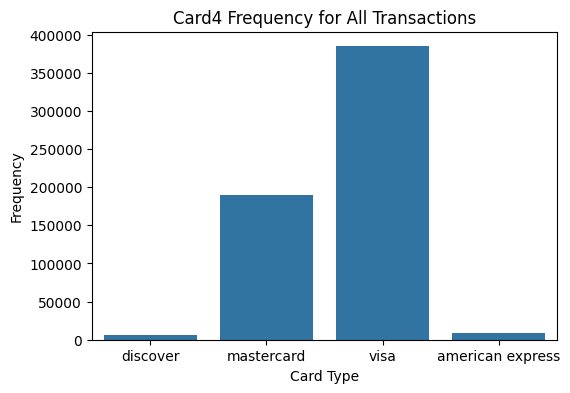

/Users/ferrisatassi/opt/miniconda3/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


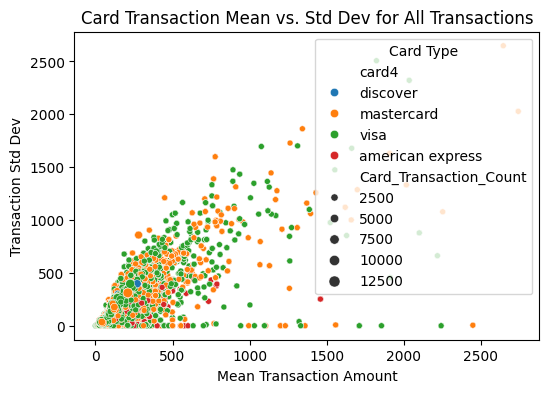

In [4]:
plt.figure(figsize=(6, 4))
sns.barplot(x='card4', y='card4_freq', data=trainDF)
plt.title("Card4 Frequency for All Transactions")
plt.ylabel('Frequency')
plt.xlabel('Card Type')
plt.show()

plt.figure(figsize=(6, 4))
sns.scatterplot(x='Card_Transaction_Mean', y='Card_Transaction_Std', size='Card_Transaction_Count', hue='card4', data=trainDF)
plt.title("Card Transaction Mean vs. Std Dev for All Transactions")
plt.xlabel('Mean Transaction Amount')
plt.ylabel('Transaction Std Dev')
plt.legend(title='Card Type')
plt.show()

**Visualization: Credit Card Distrbutor Frequency Histogram + Card Transaction Mean vs Std Dev Scatter Plot (All Transactions)**

The first histogram is a visualization of credit card ditrubutor frequencies utilizing the newly constructed feature. This looks the same as graph from part a) on credit card distrubtors, thus it can be seen that feature was constructed successfully. Once again Mastercard and Visa are the most utilized across all transactions.

Second Visualization is a scatterplot of Mean Transaction Amount by Transaction Std Dev with shading referring to card type and size referring to count. It can be seen that there is a positive correlation between mean and std dev of transactions. Cards with higher transaction amounts tend to cluster at lower mean/std dev values. Outliers with high means and std devs tend to occur at a much lower rate.

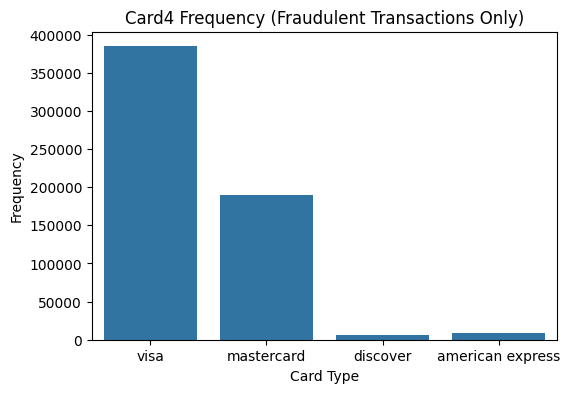

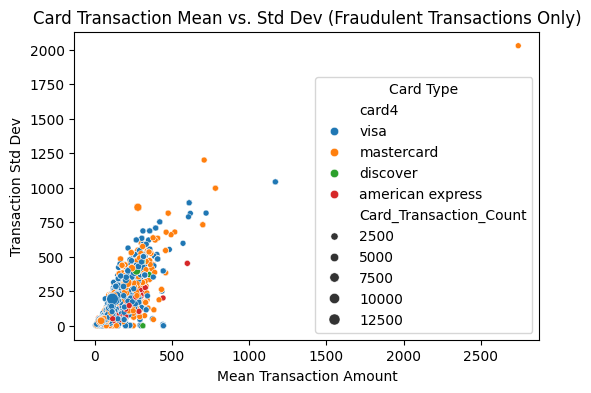

In [5]:
fraudDF = trainDF[trainDF['isFraud'] == 1]

plt.figure(figsize=(6, 4))
sns.barplot(x='card4', y='card4_freq', data=fraudDF)
plt.title("Card4 Frequency (Fraudulent Transactions Only)")
plt.ylabel('Frequency')
plt.xlabel('Card Type')
plt.show()

plt.figure(figsize=(6, 4))
sns.scatterplot(x='Card_Transaction_Mean', y='Card_Transaction_Std', size='Card_Transaction_Count', hue='card4', data=fraudDF)
plt.title("Card Transaction Mean vs. Std Dev (Fraudulent Transactions Only)")
plt.xlabel('Mean Transaction Amount')
plt.ylabel('Transaction Std Dev')
plt.legend(title='Card Type')
plt.show()

**Visualization: Credit Card Distrbutor Frequency Histogram + Card Transaction Mean vs Std Dev Scatter Plot (Only Fraudulent Transactions)**

<p style="font-size:10px">The first histogram is a visualization of credit card ditrubutor frequencies utilizing the newly constructed feature but only for fraudulent transactions. Once again it matches graph from part a) for fraudulent transactions, thus feature engineering was done successfully. </p>

<p style="font-size:10px">Second Visualization is a scatterplot of Mean Transaction Amount by Transaction Std Dev, for only fraudulent transactions, with shading referring to card type and size referring to count. It follows the same trend as the graph for all transactions, positive correlations with lower mean/std dev outliers more present than outliers iwth high means/std devs. This means that most fraudulent transactions (outliers) will be found with lower transaction amounts.</p>

In [6]:
%store trainDF

Stored 'trainDF' (DataFrame)
